In [264]:
import numpy as np
import seaborn as sns

In [4]:
#La llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa λ
#vehículos/hora. En el trabajo práctico se incluye un archivo con números pseudoaleatorios que
#representan los tiempos entre arribos de dichos vehículos.
# a) Realice una estimación de la tasa de arribos y proponga un test para evaluar si los
#números pseudoaleatorios provistos siguen la distribución esperada.
# b) Utilizando el GCL implementado en el Ejercicio 1 a) simular la llegada de vehículos durante
#un mes. Graficar la cantidad de arribos en función del tiempo.
# c) Generar 1000 realizaciones del proceso de Poisson para estimar las siguientes
#probabilidades:
# 1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.
# 2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
# 3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.
#Comparar con los valores teóricos.

## Ejercicio 4

###  a. 

In [5]:
Z = np.loadtxt('docs/tiempos_entre_arribos.txt')

<AxesSubplot:ylabel='Count'>

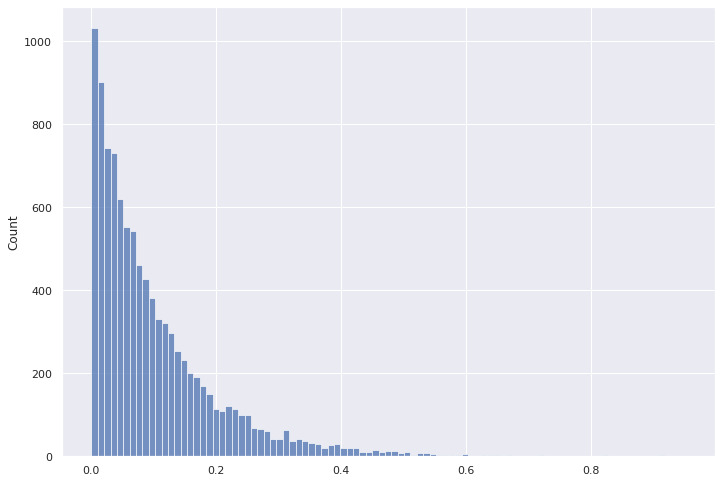

In [263]:
# Por definicion de Proceso de Poisson, el tiempo entre arribos debe 
# una distribución exponencial.
sns.histplot(Z)

In [8]:
# A priori sigue una distribución exponencial. Por propiedad E[Z] = 1 / lambda.
# Utilizando el estimador por máxima verosimilitud se llega que lambda ~ 1 / avg(Z)

# Estimación de la tasa
tasa = len(Z) / sum(Z)
tasa

9.889245996494681

In [9]:
# Test Anderson-Darling
# H0: Z sigue una distribución exponencial.
# H1: Z no sigue una distribución exponencial.
from numpy.random import randn
from scipy.stats import anderson

#Ejecutamos el test
resultado = anderson(Z, dist='expon')

print('Estadístico: %.3f' % resultado.statistic)

for i in range(len(resultado.critical_values)):
    nivel_significancia, umbral = resultado.significance_level[i]/100, resultado.critical_values[i]
    if resultado.statistic < resultado.critical_values[i]:
        print('%.3f: %.3f, Datos exponenciales (No se puede rechazar H0)' % (nivel_significancia, umbral))
    else:
        print('%.3f: %.3f, Datos No exponenciales (Se rechaza H0)' % (nivel_significancia, umbral))

Estadístico: 2.003
0.150: 0.922, Datos No exponenciales (Se rechaza H0)
0.100: 1.078, Datos No exponenciales (Se rechaza H0)
0.050: 1.341, Datos No exponenciales (Se rechaza H0)
0.025: 1.606, Datos No exponenciales (Se rechaza H0)
0.010: 1.957, Datos No exponenciales (Se rechaza H0)


In [10]:
# Para los niveles de significancia analizados 0.01, 0.025, 0.05, 0.1 y 0.15 se rechaza Ho
# Por lo que podemos concluir que Z no sigue una distribucion exponencial.

### b.

In [11]:
# GCL 
# TODO: borrar esto al mergear.

padrones = [90638, 90638, 99714, 101939, 99689]
avg_padrones = sum(padrones) / len(padrones)
seed = int(avg_padrones)

modulo = 4294967296
multiplicador = 1013904223
incremento = 1664525

def next(num):
    return (multiplicador * num + incremento) % modulo

In [57]:
# Genero un vector de distribución exponencial a partir del generador utilizando la inversa
# de la funcion de densidad de la misma.

# Inversa de la densidad de una VA exponencial
def inv_exponential(x, mu):
    return (- np.log(x) / mu)

def exponential(num, mu=tasa):
    return inv_exponential(num / modulo, mu)

def sim_poisson(seed, n=10000, t_limit=-1):
    accum = 0
    num = seed
    P = []
    while (accum <= t_limit if t_limit > 0 else True) and (len(P) < n if n > 0 else True):
        num = next(num)
        z = exponential(num)
        accum += z
        P.append(accum)
        
    return P

In [ ]:
# Un mes, se asumen 31 días -> 744 hs
P = sim_poisson(int(avg_padrones), n=-1, t_limit=744)

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(P, range(len(P)), drawstyle='steps-post')

/home/bacanavese/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


## c

In [253]:
from scipy.stats import poisson

TOTAL_MUESTRAS = 1000

# 1000 muestras de Poisson con lamda = 9.88
muestras = [sim_poisson(x, t_limit=74) for x in range(0, TOTAL_MUESTRAS)]

def positivos(muestras, f):
    return sum([1 for x in muestras if f(x)])

### a.

Probabilidad que el primer vehículo arribe antes de los 10 minutos.

In [ ]:
# La calculamos como: P(X >= 1) = 1 - P(X = 0), para t = 1/6 hs.

In [260]:
# Las muestras que caen dentro del intervalo [0, t).
def first_bucket(P, t):
    N = []
    for x in P:
        if x < t:
            N.append(x)
        else:
            return N
    

In [254]:
# Estimación
T_A = 1/6

# Primer arribo antes de los 10 min.
def cumple_a(poisson):
    return poisson[0] < T_A

positivos(muestras, cumple_a) / TOTAL_MUESTRAS

0.807

In [234]:
# Teoricamente
# P(X >= 1) = 1 - P (X = 0)
1 - poisson.pmf(0, tasa * T_A)

0.8076055651533732

## b

In [ ]:
# Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
# La calculamos como: P(X < 12) = P(X = 0) +...+ P(X = 11), para t = 1 hr. 

In [261]:
# Estimación
T_B = 1

def cumple_b(poisson):
    return len(first_bucket(poisson, T_B)) < 12
    
positivos(muestras, cumple_b) / TOTAL_MUESTRAS

0.697

In [240]:
# Teoricamente
sum([poisson.pmf(X, tasa * T_B) for X in range(0, 12)])

0.7093005827751792

## c

Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

In [7]:
# P (X >= 750) = 1 - P(X < 750) = ...

In [262]:
# Estimación
T_C = 72

def cumple_c(poisson):
    return len(first_bucket(poisson, T_C)) >= 750
    
positivos(muestras, cumple_c) / TOTAL_MUESTRAS

0.079

In [231]:
# Teoricamente
mu = tasa * T_C
1 - sum([poisson.pmf(k, mu) for k in range(0, 750)])

0.0809784853589276